In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.transforms import RandomApply
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import torch.optim as optim
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Betöltés

In [3]:
data_dir = Path("../train")
subfolders = ["close_eyes", "open_eyes"]

files = []
for label in subfolders:
    folder = data_dir / label
    if not folder.exists():
        print(f"Mappa nem található: {folder}")
        continue
    for file in folder.iterdir():
        if file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            files.append((str(file.resolve()), label))

#random.shuffle(files)

df = pd.DataFrame(files, columns=["filepath", "label"])

print("Összes kép:", len(df))

Összes kép: 81675


Előkészítés

In [4]:
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.RandomHorizontalFlip(p=0.5)
    #transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
    #transforms.ColorJitter(contrast=0.3, brightness=0.2)
])

transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [5]:
class EyesDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label_map = {"close_eyes": 0, "open_eyes": 1}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["filepath"]).convert("L")
        if self.transform:
            img = self.transform(img)
        label = self.label_map[row["label"]]
        return img, label

In [6]:
BATCH = 32

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

train_dataset = EyesDataset(train_df, transform=transform_train)
val_dataset = EyesDataset(val_df, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}")

Train: 65340, Validation: 16335


Model

In [7]:
class EyeCNN(nn.Module):
    def __init__(self):
        super(EyeCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
model = EyeCNN().to(device)

In [8]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), 
                       lr=0.00005, 
                       weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.5, 
                                                 patience=3, 
                                                 verbose=True)

In [9]:
num_epochs = 20

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0
    train_preds, train_labels = [], []

    for imgs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):

        imgs = imgs.to(device)
        labels = labels.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # paraméterek frissítése

        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_preds.extend(preds.cpu().numpy().flatten().tolist())
        train_labels.extend(labels.cpu().numpy().flatten().tolist())

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1}: Loss: {avg_loss:.4f}, Training Accuracy: {acc:.4f}")
    

    # Validáció
    model.eval()
    running_val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).float().view(-1, 1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_preds.extend(preds.cpu().numpy().flatten().tolist())
            val_labels.extend(labels.cpu().numpy().flatten().tolist())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)
    print(f"Validation: Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")

    scheduler.step(avg_val_loss) # tanulási ráta frissítése

Training Epoch 1/20:   0%|          | 0/2042 [00:00<?, ?it/s]

Training Epoch 1/20: 100%|██████████| 2042/2042 [13:34<00:00,  2.51it/s]


Epoch 1: Loss: 0.2362, Training Accuracy: 0.9086
Validation: Loss: 0.1496, Accuracy: 0.9466


Training Epoch 2/20: 100%|██████████| 2042/2042 [01:08<00:00, 29.78it/s]


Epoch 2: Loss: 0.1534, Training Accuracy: 0.9453
Validation: Loss: 0.1571, Accuracy: 0.9399


Training Epoch 3/20: 100%|██████████| 2042/2042 [01:08<00:00, 29.80it/s]


Epoch 3: Loss: 0.1330, Training Accuracy: 0.9525
Validation: Loss: 0.1171, Accuracy: 0.9562


Training Epoch 4/20: 100%|██████████| 2042/2042 [01:08<00:00, 29.76it/s]


Epoch 4: Loss: 0.1197, Training Accuracy: 0.9577
Validation: Loss: 0.0964, Accuracy: 0.9662


Training Epoch 5/20: 100%|██████████| 2042/2042 [01:08<00:00, 29.75it/s]


Epoch 5: Loss: 0.1105, Training Accuracy: 0.9607
Validation: Loss: 0.0910, Accuracy: 0.9676


Training Epoch 6/20: 100%|██████████| 2042/2042 [01:08<00:00, 29.73it/s]


Epoch 6: Loss: 0.1006, Training Accuracy: 0.9645
Validation: Loss: 0.0888, Accuracy: 0.9680


Training Epoch 7/20: 100%|██████████| 2042/2042 [01:09<00:00, 29.48it/s]


Epoch 7: Loss: 0.0945, Training Accuracy: 0.9665
Validation: Loss: 0.0758, Accuracy: 0.9725


Training Epoch 8/20: 100%|██████████| 2042/2042 [01:09<00:00, 29.39it/s]


Epoch 8: Loss: 0.0893, Training Accuracy: 0.9689
Validation: Loss: 0.0770, Accuracy: 0.9721


Training Epoch 9/20: 100%|██████████| 2042/2042 [01:09<00:00, 29.56it/s]


Epoch 9: Loss: 0.0839, Training Accuracy: 0.9708
Validation: Loss: 0.0763, Accuracy: 0.9718


Training Epoch 10/20: 100%|██████████| 2042/2042 [01:09<00:00, 29.58it/s]


Epoch 10: Loss: 0.0795, Training Accuracy: 0.9722
Validation: Loss: 0.0650, Accuracy: 0.9754


Training Epoch 11/20: 100%|██████████| 2042/2042 [01:09<00:00, 29.43it/s]


Epoch 11: Loss: 0.0724, Training Accuracy: 0.9746
Validation: Loss: 0.0598, Accuracy: 0.9783


Training Epoch 12/20: 100%|██████████| 2042/2042 [01:08<00:00, 29.65it/s]


Epoch 12: Loss: 0.0687, Training Accuracy: 0.9761
Validation: Loss: 0.0575, Accuracy: 0.9800


Training Epoch 13/20: 100%|██████████| 2042/2042 [01:08<00:00, 29.69it/s]


Epoch 13: Loss: 0.0659, Training Accuracy: 0.9766
Validation: Loss: 0.0600, Accuracy: 0.9798


Training Epoch 14/20: 100%|██████████| 2042/2042 [01:09<00:00, 29.57it/s]


Epoch 14: Loss: 0.0618, Training Accuracy: 0.9778
Validation: Loss: 0.0517, Accuracy: 0.9826


Training Epoch 15/20: 100%|██████████| 2042/2042 [01:08<00:00, 29.69it/s]


Epoch 15: Loss: 0.0587, Training Accuracy: 0.9793
Validation: Loss: 0.0486, Accuracy: 0.9825


Training Epoch 16/20: 100%|██████████| 2042/2042 [01:10<00:00, 29.08it/s]


Epoch 16: Loss: 0.0559, Training Accuracy: 0.9800
Validation: Loss: 0.0469, Accuracy: 0.9840


Training Epoch 17/20: 100%|██████████| 2042/2042 [01:09<00:00, 29.58it/s]


Epoch 17: Loss: 0.0540, Training Accuracy: 0.9810
Validation: Loss: 0.0503, Accuracy: 0.9832


Training Epoch 18/20: 100%|██████████| 2042/2042 [01:09<00:00, 29.53it/s]


Epoch 18: Loss: 0.0529, Training Accuracy: 0.9816
Validation: Loss: 0.0552, Accuracy: 0.9796


Training Epoch 19/20: 100%|██████████| 2042/2042 [01:09<00:00, 29.43it/s]


Epoch 19: Loss: 0.0500, Training Accuracy: 0.9826
Validation: Loss: 0.0489, Accuracy: 0.9822


Training Epoch 20/20: 100%|██████████| 2042/2042 [01:09<00:00, 29.50it/s]


Epoch 20: Loss: 0.0495, Training Accuracy: 0.9826
Validation: Loss: 0.0470, Accuracy: 0.9837


In [10]:
val_precision = precision_score(val_labels, val_preds, zero_division=0)
val_recall = recall_score(val_labels, val_preds, zero_division=0)
val_f1 = f1_score(val_labels, val_preds, zero_division=0)

print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-score: {val_f1:.4f}")

Precision: 0.9865
Recall: 0.9812
F1-score: 0.9839


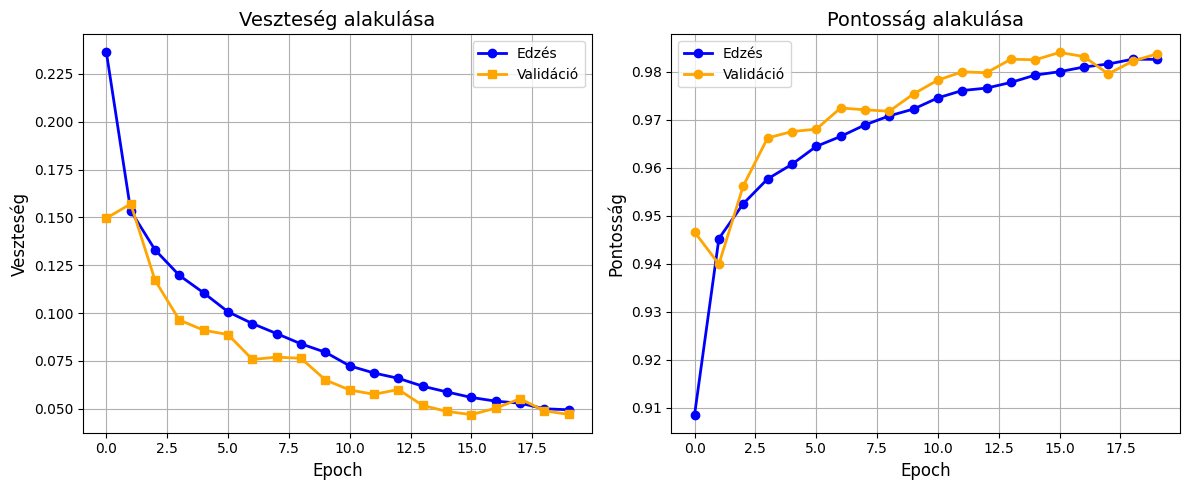

In [18]:
epochs_range = range(num_epochs)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Edzés", marker="o", markersize=6, linewidth=2, color='blue')
plt.plot(epochs_range, val_losses, label="Validáció", marker="s", markersize=6, linewidth=2, color='orange')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Veszteség", fontsize=12)
plt.title("Veszteség alakulása", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Edzés", marker="o", markersize=6, linewidth=2, color='blue')
plt.plot(epochs_range, val_accuracies, label="Validáció", marker="o", markersize=6, linewidth=2, color='orange')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Pontosság", fontsize=12)
plt.title("Pontosság alakulása", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

Test

In [12]:
test_data_dir = Path("../test")
test_subfolders = ["close_eyes", "open_eyes"]

test_files = []
for label in test_subfolders:
    folder = test_data_dir / label
    if not folder.exists():
        print(f"Mappa nem található: {folder}")
        continue
    for file in folder.iterdir():
        if file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            test_files.append((str(file.resolve()), label))

test_df = pd.DataFrame(test_files, columns=["filepath", "label"])
print("Összes test kép:", len(test_df))

Összes test kép: 3223


In [13]:
test_dataset = EyesDataset(test_df, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

In [19]:
model.eval()
running_test_loss = 0.0
test_preds, test_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).float().view(-1, 1)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        test_preds.extend(preds.cpu().numpy().flatten().tolist())
        test_labels.extend(labels.cpu().numpy().flatten().tolist())

avg_test_loss = running_test_loss / len(test_loader)
test_acc = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, zero_division=0)
test_recall = recall_score(test_labels, test_preds, zero_division=0)
test_f1 = f1_score(test_labels, test_preds, zero_division=0)

print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_f1:.4f}")

Precision: 0.9993
Recall: 0.8129
F1-score: 0.8965


Mentés

In [15]:
torch.save(model.state_dict(), "test3cnn.pth")
print("modell mentve")

modell mentve
